In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

In [3]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)


5


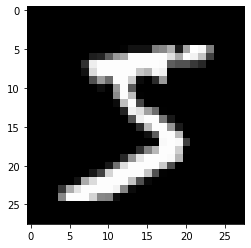

In [4]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


Here, I will first implement a BNN such as in the PAI Task 2. Thus it will be a BNN that is trained via Bayes by Backprop. We will need to change this to train the BNN via SG-MCMC as we said in the Proposal.

First, we need to define the Prior distributions which we will later use in the BNN.

In [5]:
class Prior(nn.Module, abc.ABC):
    """
    This class is a base class for all priors.
    It implements the log_likelihood and sample methods.
    The forward method is not used, but is required by nn.Module.
    This part of the code is inspired by the code from Vincent Fortuin:
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/prior/base.py
    """
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        pass
    
    @abc.abstractmethod
    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Don't use this method, we only implement it because nn.Module requires it
        Vincent Fortuin uses the forward to return the parameter value using self.p
        """
        return self.log_likelihood(x)


In [29]:
class Isotropic_Gaussian(Prior):
    """
    Isotropic Gaussian prior
    """

    def __init__(self, mu: float = 0., sigma: float = 1.):
        super(Isotropic_Gaussian, self).__init__()
        assert sigma > 0, "Sigma must be positive"
        self.mu = mu
        self.sigma = sigma

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        return dist.Normal(self.mu, self.sigma).log_prob(x).sum()

    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        return dist.Normal(self.mu, self.sigma).sample()



class Multivariate_Gaussian(Prior):
    """
    Multivariate Gaussian prior
    """
    def __init__(self, mu: torch.Tensor, sigma: torch.Tensor):
        super(Multivariate_Gaussian, self).__init__()
        assert sigma.shape == mu.shape, "Sigma and mu must have the same shape"
        self.mu = mu
        self.sigma = sigma

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        sigma_resized = torch.reshape(self.sigma, (-1, ))
        mu_resized = torch.reshape(self.mu, (-1, ))
        covariance = torch.eye(sigma_resized.shape[0]) * sigma_resized

        return dist.MultivariateNormal(mu_resized, covariance).log_prob(x).sum()


    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        sigma_resized = torch.reshape(self.sigma, (-1, ))
        mu_resized = torch.reshape(self.mu, (-1, ))
        covariance = torch.diag(sigma_resized)  

        return dist.MultivariateNormal(mu_resized, covariance).sample()



Next, we need to define a basic module for one single Bayesian Layer. This module will then be used as building block for the full BNN. 


In [14]:
class Linear_Layer(nn.Linear):
    """
    Bayesian Linear Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """ 
    def __init__(self, in_features, out_features, bias = True):
        super().__init__(in_features, out_features, bias)
        self.in_features = in_features
        self.out_features = out_features
        self.with_bias = bias

        # create a prior for the weights and biases using the Isotropic Gaussian prior
        self.weight_prior = Isotropic_Gaussian(mu = 0., sigma = 1.)

        if self.with_bias:
            self.bias_prior = Isotropic_Gaussian(mu = 0., sigma = 1.)
        
        # create a variational posterior for the weights and biases as Instance of  Multivariate Gaussian
        self.weight_posterior = Multivariate_Gaussian(
            mu = torch.nn.Parameter(torch.zeros(out_features, in_features)),
            sigma = torch.nn.Parameter(torch.ones(out_features, in_features))
        )
        
        if self.with_bias:
            self.bias_posterior = Multivariate_Gaussian(
                mu = torch.nn.Parameter(torch.zeros(out_features)),
                sigma = torch.nn.Parameter(torch.ones(out_features))
            )
        else:
            self.register_parameter('bias', None)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Same procedure as explained in the paper of Blundell et al. (2015):
        use reparameterization trick to sample weights and biases from the variational posterior
        """
        # usample random noise from the standard normal distribution
        epsilon = torch.randn_like(self.weight_posterior.mu)

        # sample weights and biases from the variational posterior
        weight = self.weight_posterior.mu + torch.multiply(epsilon, torch.log(1 + torch.exp(self.weight_posterior.sigma)))

        # compute the log prior of the weights and biases
        log_prior = self.weight_prior.log_likelihood(weight)

        # compute the log variational posterior of the weights and biases
        log_posterior = self.weight_posterior.log_likelihood(weight)

        # adjust for the bias
        if self.with_bias:
            bias = self.bias_posterior.mu + torch.multiply(epsilon, torch.log(1 + torch.exp(self.bias_posterior.sigma)))
            log_prior += self.bias_prior.log_likelihood(bias)
            log_posterior += self.bias_posterior.log_likelihood(bias)
        else:
            bias = None


        kl_divergence = log_posterior - log_prior

        # compute the output of the layer
        output = F.linear(x, weight, bias)
        return output, kl_divergence


        




In [30]:

class Bayesian_Neural_Network(nn.Module):
    """
    Bayesian Neural Network that will be trained using the BNN implementation
    """ 
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims

        # create the layers of the network
        self.layers = nn.ModuleList()

        # create the input layer
        self.layers.append(Linear_Layer(self.input_dim, self.hidden_dims[0]))

        # create the hidden layers
        for i in range(len(self.hidden_dims) - 1):
            self.layers.append(Linear_Layer(self.hidden_dims[i], self.hidden_dims[i + 1]))
            self.layers.append(nn.ReLU())

        # create the output layer
        self.layers.append(Linear_Layer(self.hidden_dims[-1], self.output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network
        """
        kl_divergence = 0
        for layer in self.layers:
            x, kl = layer(x)
            kl_divergence += kl

        return x, kl_divergence

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        Predict the output of the network and return the output
        """
        with torch.no_grad():
            output, _ = self.forward(x)
            return output





In [32]:
# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100])

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# train the model
epochs = 20

for epoch in tqdm.tqdm(range(epochs)):
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # forward pass
        output, kl_divergence = model(x)

        # compute the loss
        loss = F.cross_entropy(output, y) + kl_divergence

        # backward pass
        loss.backward()
        optimizer.step()

        # print the loss
        if i % 2 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}")

        

  0%|          | 0/20 [00:06<?, ?it/s]


ValueError: The right-most size of value must match event_shape: torch.Size([10, 784]) vs torch.Size([7840]).

In [ ]:


# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_size=28*28, hidden_size=100, output_size=10)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs = 15
progress_bar = tqdm(epochs)

for epoch in progress_bar:
    for x, y in train_loader:
        # reshape the input
        x = x.view(-1, 28*28)

        # compute the output of the network
        y_hat, log_prior, log_posterior = model(x)

        # compute the loss
        loss = loss_fn(y_hat, y) - log_prior + log_posterior

        # compute the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # reset the gradients
        optimizer.zero_grad()

    # compute the accuracy
    accuracy = (model.predict_class(x) == y).float().mean()

    # update the progress bar
    progress_bar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}")




In [ ]:
class Conv_Layer(nn.Conv2d):
    """
    Bayesian Convolutional Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = True):
        super(Conv_Layer, self).__init__()
        pass